In [43]:
from dataclasses import dataclass
from datetime import datetime

import sklearn.metrics as metrics
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np 
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from torchfuzzy import FuzzyLayer, DefuzzyLinearLayer, FuzzyBellLayer
import os

os.environ['CUDA_LAUNCH_BLOCKING']="1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"

In [44]:
batch_size = 256

nz = 100 
ngf = 32 
ndf = 64

niter = 50

prefix = f"fuzzy_gan_anomaly_detection"
writer = SummaryWriter(f'runs/mnist/{prefix}_{datetime.now().strftime("%Y%m%d-%H%M%S")}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Load MNIST

In [45]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x.view(-1, 28, 28) - 0.5),
])

In [46]:
# загружаем обучающую выборку

def get_target_and_mask(target_label):
    t = torch.zeros(10)
    t[target_label] = 1.0
    return t.to(device) 

train_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=True, 
    transform = transform,
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x))
)
len(train_data)

60000

In [47]:
# загружаем тестовую выборку
test_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=False, 
    transform=transform, 
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x))
)
len(test_data)

10000

In [48]:
# Создаем итераторы датасетов
train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False,
)


### Load EMNIST

In [49]:
emnist_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x.view(-1, 28, 28) - 0.5),
])

emnist_test = pd.read_csv("./data/EMNIST/emnist-letters.zip")
emnist_y = emnist_test["label"]
emnist_x = emnist_test.drop(labels = ["label"], axis = 1) 
del emnist_test 

emnist_x = emnist_x / 255.0
emnist_x = emnist_x.values.reshape(-1, 28, 28)
emnist_x = [torch.tensor(emnist_transform(a), dtype=torch.float32, device=device) for a in emnist_x]

len(emnist_x)

emnist_mapping = pd.read_csv("./data/EMNIST/emnist-letters-mapping.txt", sep=' ', header=None)
emnist_mapping.columns=("EMNIST","UP","LO")
emnist_mapping["Letter"] = emnist_mapping.apply(lambda row: chr(row["UP"])+chr(row["LO"]), axis=1)
emnist_mapping = dict(zip(emnist_mapping["EMNIST"], emnist_mapping["Letter"]))

emnist_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.stack(emnist_x), torch.Tensor(np.array(emnist_y))), 
    batch_size=batch_size, 
    shuffle=False,
)

C:\Users\Юрий\AppData\Local\Temp\ipykernel_10932\58620865.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  emnist_x = [torch.tensor(emnist_transform(a), dtype=torch.float32, device=device) for a in emnist_x]


## DCGAN Model

In [50]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [51]:
class Generator(nn.Module):
    def __init__(self, ngf, nz, nc=1):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(    ngf,      nc, kernel_size=1, stride=1, padding=2, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        output = self.main(input)
        return output

netG = Generator(ngf, nz).to(device)
netG.apply(weights_init)
num_params = sum(p.numel() for p in netG.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params:,}')

print(netG)

Number of parameters: 1,098,720
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(32, 1, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2), bias=F

In [52]:
class Discriminator(nn.Module):
    def __init__(self, ndf):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, ndf, 4, 2, 1, bias=False),
            nn.SiLU(),
            
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.SiLU(),
            
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.SiLU(),
            
            nn.Conv2d(ndf * 4, 1, 2, 1, 1, bias=False),
            nn.Flatten(),
            nn.Linear(16, 2),
        )
        self.latent_dim = 2
        self.fuzzy_rules_real = 10
        
        self.real = nn.Sequential(
            FuzzyLayer.from_dimensions(self.latent_dim, self.fuzzy_rules_real),
            DefuzzyLinearLayer.from_array(np.repeat(1.0 / self.fuzzy_rules_real, self.fuzzy_rules_real).reshape(1,-1), trainable=False, with_norm=False)
        )
    
    def forward(self, input):
        output = self.main(input)
        r = self.real(output)
        return r.squeeze()
    

netD = Discriminator(ndf).to(device)
netD.apply(weights_init)
num_params = sum(p.numel() for p in netD.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params:,}')
print(netD)

Number of parameters: 658,260
Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): SiLU()
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): SiLU()
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): SiLU()
    (8): Conv2d(256, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), bias=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=16, out_features=2, bias=True)
  )
  (real): Sequential(
    (0): FuzzyLayer(
      (rots): ParameterList(  (0): Parameter containing: [torch.float32 of size 10x1 (cuda:0)])
    )
    (1): DefuzzyLinearLayer()
  )
)


In [53]:
# inp = torch.rand(4, 1, 28, 28).to(device)
# dd = Discriminator(1).to(device)
# dd(inp)

## Train

In [54]:
optimizerD = torch.optim.Adam(netD.parameters(), lr=0.001, betas=(0.9, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=0.001, betas=(0.9, 0.999))

fixed_noise_for_report = torch.randn(64, nz, 1, 1, device=device)

In [55]:
def keep_eigenvals_positive_loss(layer, eps = 1e-3):
    ev = layer.get_transformation_matrix_eigenvals().real.min()
    ev = torch.clamp(ev, max=eps)
    return -ev

In [56]:
def get_test_arate_distr(D):
    with torch.no_grad():
        firing_levels = []
        lab_true = []
        lab_pred = []

        for data, _ in tqdm(test_loader, desc='Test MNIST', disable=True):
            data = data.view((-1,1,28,28)).to(device)
            rates = D(data)
            firing_levels.append(rates.cpu().numpy())
            

        firing_levels = np.concatenate(firing_levels, axis=0)
        for p in firing_levels:
            lab_true.append(1)
            lab_pred.append(p)

        for data, _ in tqdm(emnist_loader, desc='Test EMNIST', disable=True):
            data = data.view((-1, 1, 28, 28)).to(device) 
            arate = D(data)
            
            for p in arate.cpu().numpy():
                lab_true.append(0)
                lab_pred.append(p)
                    
        fpr, tpr, threshold = metrics.roc_curve(lab_true, lab_pred)
        roc_auc = metrics.auc(fpr, tpr)

        return firing_levels, roc_auc, threshold

def draw_embeddings(netD, netG, epoch):
    with torch.no_grad():
        centroids_real = netD.real[0].get_centroids().detach().cpu().numpy()
        
        embedings = []
        embedings_test = []
        labels_expected = []
        
        cnt = 3
    
        for data, target in tqdm(train_loader, desc='Encoding', disable=True):
            data = data.view((-1,1,28,28)).to(device)
            embeding = netD.main(data)
            embedings.append(embeding.cpu().numpy())
            labels_expected.append(np.argmax(target.squeeze(1).cpu().numpy(), axis=1))
            cnt -= 1
            if cnt < 0:
                break
            
        embedings = np.concatenate(embedings, axis=0)
        labels_expected = np.concatenate(labels_expected, axis=0)

        cnt = 3
        with torch.no_grad():
            for data, target in tqdm(test_loader, desc='Encoding', disable=True):
                data = data.view((-1,1,28,28)).to(device)
                embeding = netD.main(data)
                embedings_test.append(embeding.cpu().numpy())
                cnt -= 1
                if cnt < 0:
                    break
        embedings_test = np.concatenate(embedings_test, axis=0)

        embedings_fake = []

    
        batch_size = 256
        latent_size = 100
        
        fixed_noise = torch.randn(batch_size, latent_size, 1, 1)
        if torch.cuda.is_available():
            fixed_noise = fixed_noise.cuda()
        fake_images = netG(fixed_noise)
        embeding = netD.main(fake_images)
        embedings_fake.append(embeding.cpu().numpy())

        embedings_fake = np.concatenate(embedings_fake, axis=0)    

        fig, ax = plt.subplots()
        
        ax.scatter(centroids_real[:, 0], centroids_real[:,1], marker='1', c='blue', s= 120)
        ax.scatter(embedings[:, 0], embedings[:, 1], cmap='tab10', c=labels_expected, s=4)
        ax.scatter(embedings_test[:, 0], embedings_test[:, 1], marker='+', c='blue', s = 1)
        ax.scatter(embedings_fake[:, 0], embedings_fake[:, 1], c='red', marker='o', s=1)
        
        ymin, ymax = ax.get_ylim()
        xmin, xmax = ax.get_xlim()
        szw = 100
        mesh = []
        for x in np.linspace(xmin, xmax, num=szw):
            for y in np.linspace(ymin, ymax, num=szw):
                mesh.append([x,y])

        x = np.array([a[0] for a in mesh]).reshape((szw,szw))
        y = np.array([a[1] for a in mesh]).reshape((szw,szw))
        inp = torch.FloatTensor(mesh).reshape((-1, 2)).to(device)
        z = netD.real(inp).detach().cpu().numpy().reshape((szw,szw))
        z_min, z_max = z.min(), z.max()
        c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
        c.set_zorder(-1)
        fig.colorbar(c, ax=ax)
        plt.show()
        writer.add_figure('Embeddings', fig, epoch)

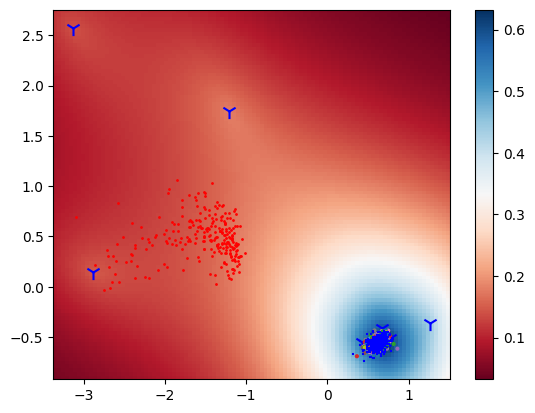

Epoch 0/50
{'G': 0.7421712522811078, 'POS': 0.49935778962804916, 'NEG': 0.15769953039732384, 'EV': 0.0, 'q20': 0.5912106037139893, 'q80': 0.6256702661514282, 'auc': 0.999741835907336}


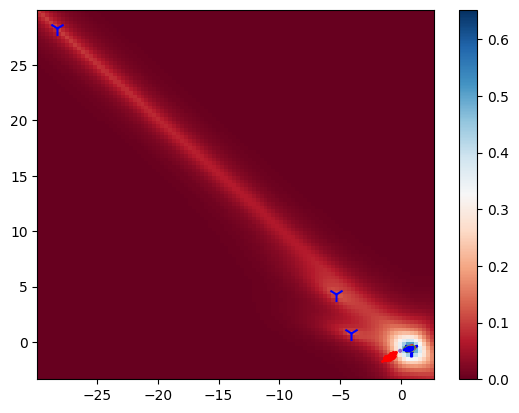

Epoch 1/50
{'G': 0.7654807222650406, 'POS': 0.6381332455797398, 'NEG': 0.15051352844593371, 'EV': 0.0, 'q20': 0.6333346605300904, 'q80': 0.7132968664169311, 'auc': 0.9898462987451737}


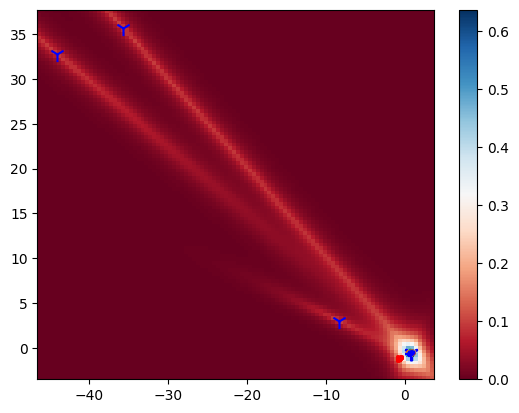

Epoch 2/50
{'G': 0.7878597452285442, 'POS': 0.6581206934249147, 'NEG': 0.14883233673394994, 'EV': 0.0024143457412719727, 'q20': 0.6752938389778137, 'q80': 0.7645616054534913, 'auc': 0.986052385135135}


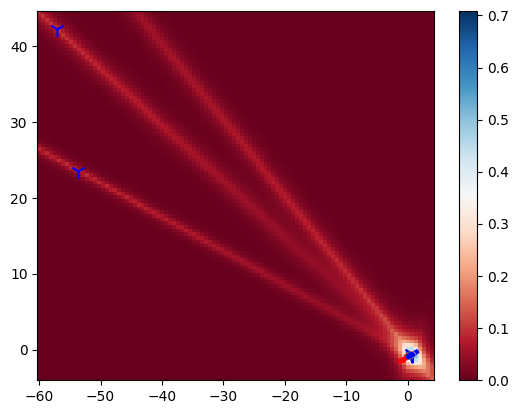

Epoch 3/50
{'G': 0.8148884747890716, 'POS': 0.7093276389101718, 'NEG': 0.13651358025505186, 'EV': 0.0008016824722290039, 'q20': 0.5910193920135498, 'q80': 0.7657325863838196, 'auc': 0.7555834145752895}


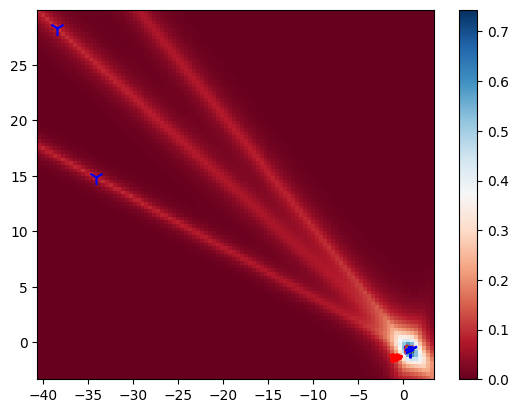

Epoch 4/50
{'G': 0.8032868240741973, 'POS': 0.7503794812141581, 'NEG': 0.12939797384624785, 'EV': 0.0001735687255859375, 'q20': 0.7310285210609436, 'q80': 0.8521191954612732, 'auc': 0.9415171211389962}


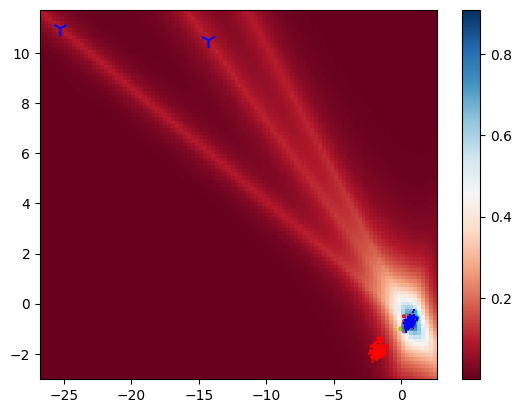

Epoch 5/50
{'G': 0.8085375133981096, 'POS': 0.7806493797200791, 'NEG': 0.12819435092362952, 'EV': 0.000303804874420166, 'q20': 0.6650429844856263, 'q80': 0.8754619598388672, 'auc': 0.9889996095559845}


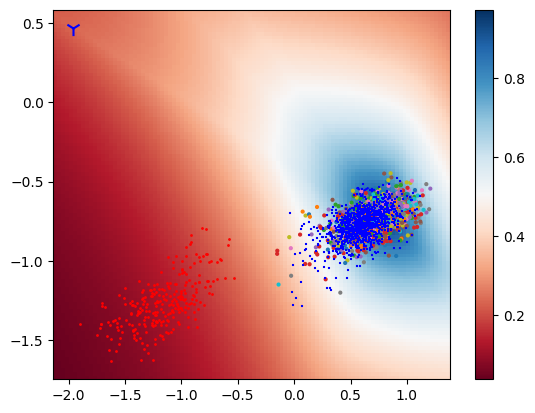

Epoch 6/50
{'G': 0.8071302911068531, 'POS': 0.8221287681701336, 'NEG': 0.12522130595876815, 'EV': 7.128715515136719e-05, 'q20': 0.6991197824478149, 'q80': 0.9071287274360657, 'auc': 0.9368003899613899}


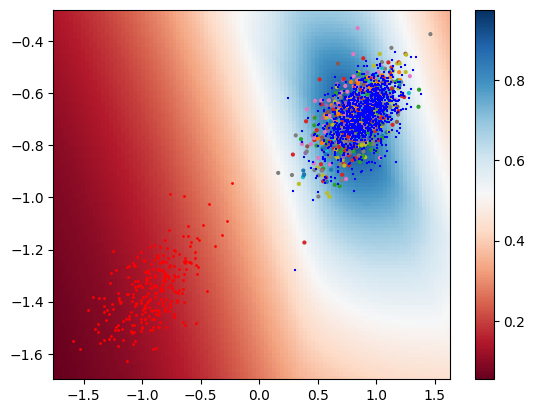

Epoch 7/50
{'G': 0.7948653784204036, 'POS': 0.8036653866159155, 'NEG': 0.138804059935377, 'EV': 0.0, 'q20': 0.7200126647949219, 'q80': 0.9169265031814576, 'auc': 0.9681865120656371}


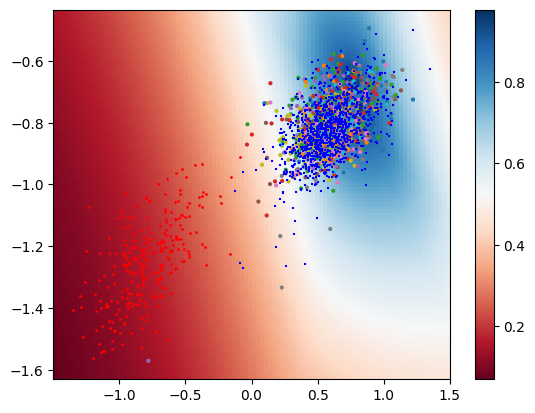

Epoch 8/50
{'G': 0.7788348611364974, 'POS': 0.8160903737900105, 'NEG': 0.1398691824141969, 'EV': 0.0, 'q20': 0.6722397089004517, 'q80': 0.895684790611267, 'auc': 0.985638318050193}


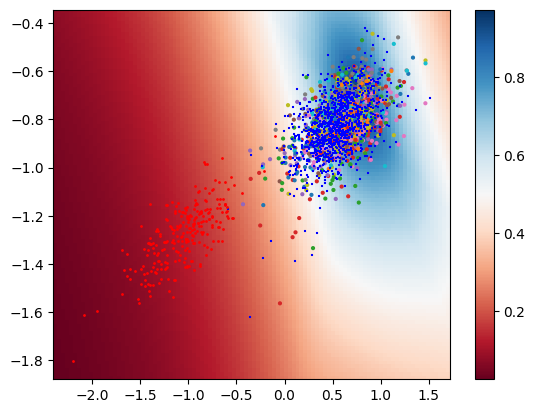

Epoch 9/50
{'G': 0.8286314464629965, 'POS': 0.829471015676539, 'NEG': 0.1260249688904336, 'EV': 0.0, 'q20': 0.6241462588310241, 'q80': 0.881479024887085, 'auc': 0.9091389247104247}


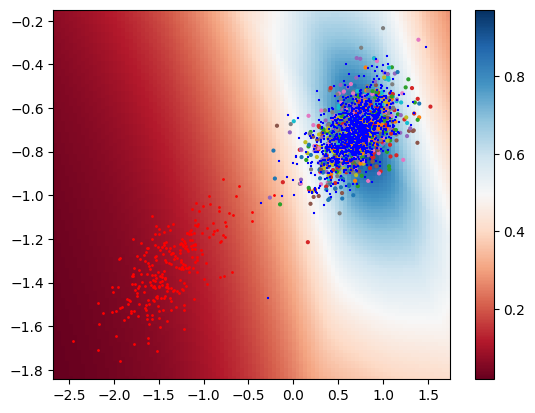

Epoch 10/50
{'G': 0.8159712634188063, 'POS': 0.8163701123379646, 'NEG': 0.1335298092599879, 'EV': 0.0, 'q20': 0.6863996744155884, 'q80': 0.9098939180374146, 'auc': 0.9624344160231659}


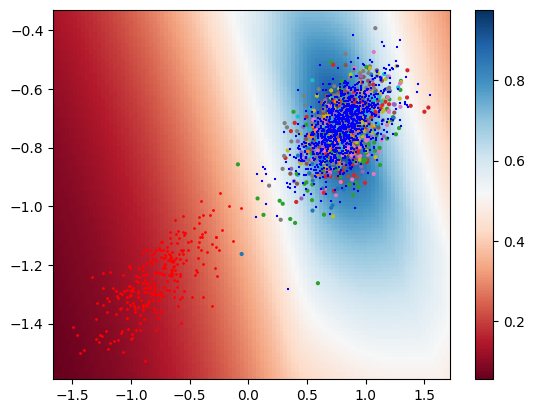

Epoch 11/50
{'G': 0.7793367251436761, 'POS': 0.8109448334004017, 'NEG': 0.15645828136104217, 'EV': 0.0, 'q20': 0.7127880930900574, 'q80': 0.9186707019805909, 'auc': 0.8025994092664093}


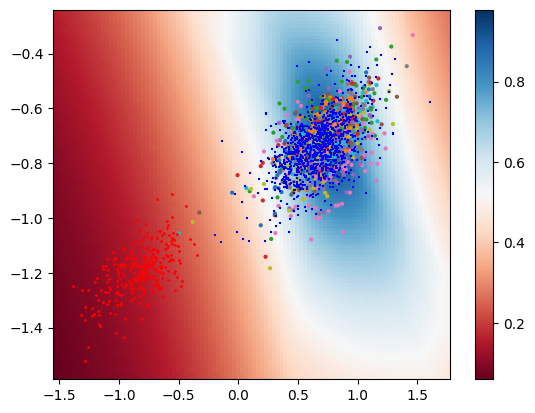

Epoch 12/50
{'G': 0.7567329612184078, 'POS': 0.7981594770512682, 'NEG': 0.16757986295096416, 'EV': 0.0, 'q20': 0.7071263074874878, 'q80': 0.9142879128456116, 'auc': 0.9574628194980696}


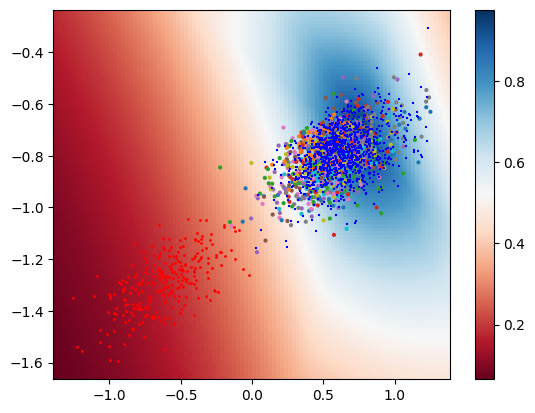

Epoch 13/50
{'G': 0.7638764792300285, 'POS': 0.7945412207157054, 'NEG': 0.15701244269755293, 'EV': 0.0, 'q20': 0.6434925556182861, 'q80': 0.8914290308952332, 'auc': 0.9992894387065638}


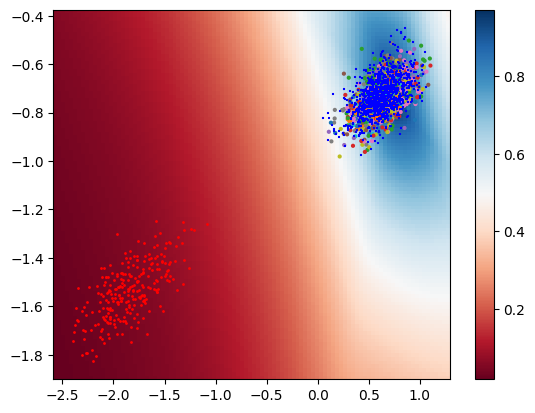

Epoch 14/50
{'G': 0.7868275524453914, 'POS': 0.7821774404099647, 'NEG': 0.1492466455206592, 'EV': 0.0, 'q20': 0.7148346662521362, 'q80': 0.9195993065834045, 'auc': 0.8652935294401544}


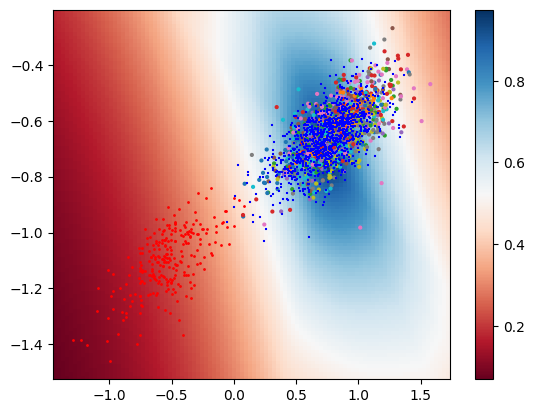

Epoch 15/50
{'G': 0.7695380431540468, 'POS': 0.7821188028822554, 'NEG': 0.16465110724118162, 'EV': 0.0, 'q20': 0.7042907238006592, 'q80': 0.9113968729972839, 'auc': 0.987154182915058}


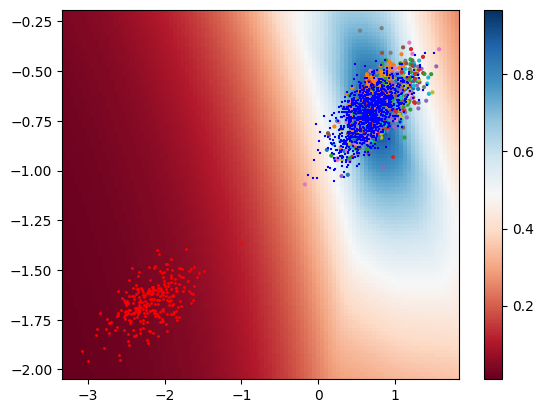

Epoch 16/50
{'G': 0.8097527545817355, 'POS': 0.7847555449668397, 'NEG': 0.13940047542465495, 'EV': 0.0, 'q20': 0.6959128975868225, 'q80': 0.9138539433479309, 'auc': 0.7099801882239383}


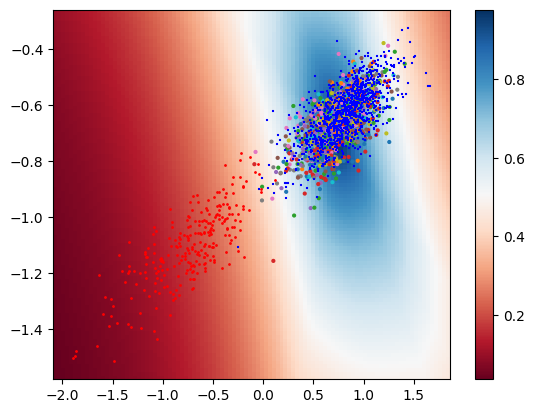

Epoch 17/50
{'G': 0.7539994228393474, 'POS': 0.7783710292045106, 'NEG': 0.17708046929712626, 'EV': 0.0, 'q20': 0.6074772953987122, 'q80': 0.8901542901992798, 'auc': 0.8687709034749033}


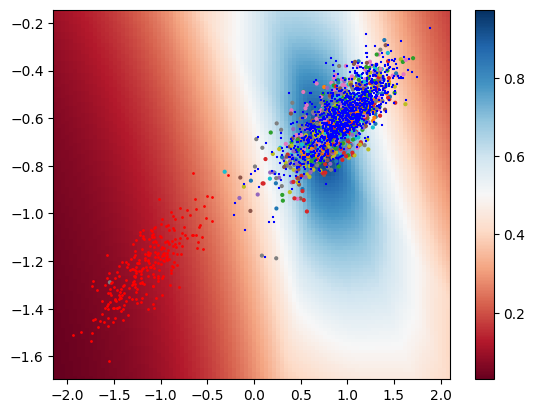

Epoch 18/50
{'G': 0.7361644171653909, 'POS': 0.7652566990953811, 'NEG': 0.19371916182497714, 'EV': 0.0, 'q20': 0.5313026547431946, 'q80': 0.8604708552360535, 'auc': 0.6254387533783784}


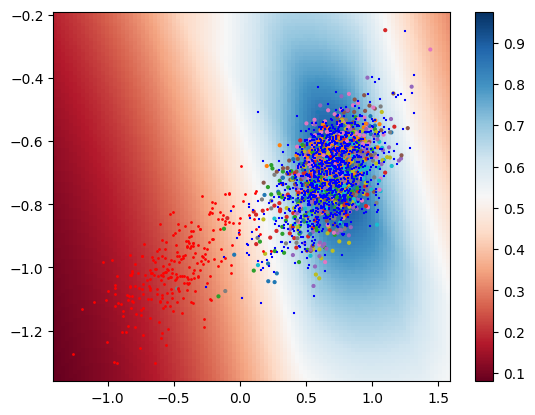

Epoch 19/50
{'G': 0.7435457384332698, 'POS': 0.7544485010999314, 'NEG': 0.18859319501417748, 'EV': 0.0, 'q20': 0.6603150129318237, 'q80': 0.9062911391258239, 'auc': 0.9946233132239384}


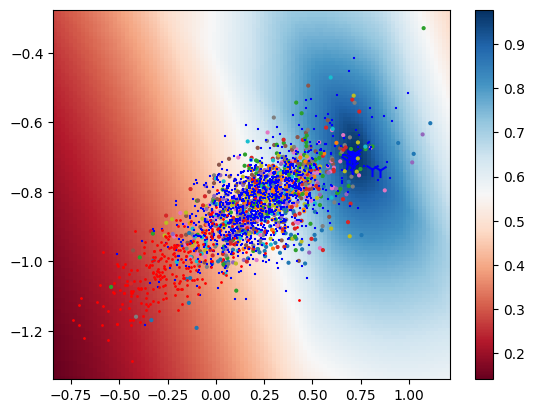

Epoch 20/50
{'G': 0.7453297735528743, 'POS': 0.7725449090308332, 'NEG': 0.18233599701222586, 'EV': 0.0, 'q20': 0.4130304753780365, 'q80': 0.6788931608200073, 'auc': 0.7415262331081081}


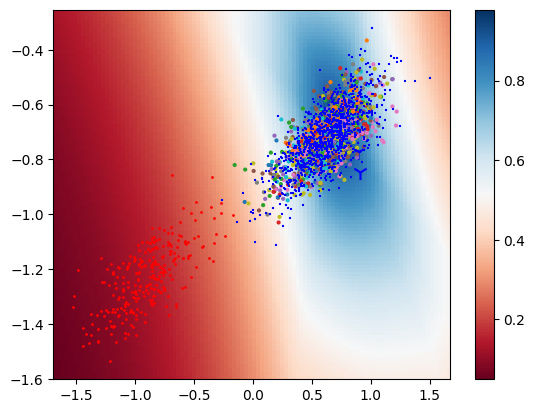

Epoch 21/50
{'G': 0.7333430064485428, 'POS': 0.7725883630996054, 'NEG': 0.18732405983387157, 'EV': 0.0, 'q20': 0.6585992455482483, 'q80': 0.9108659267425537, 'auc': 0.9959306636100386}


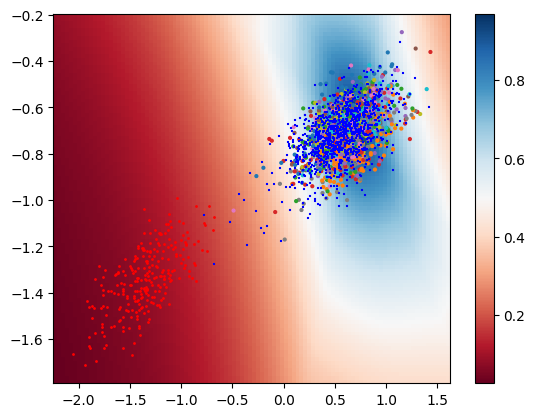

Epoch 22/50
{'G': 0.7355213160210468, 'POS': 0.7482036406689502, 'NEG': 0.19222128606857136, 'EV': 0.0, 'q20': 0.6344923615455628, 'q80': 0.8947166681289673, 'auc': 0.9957856978764478}


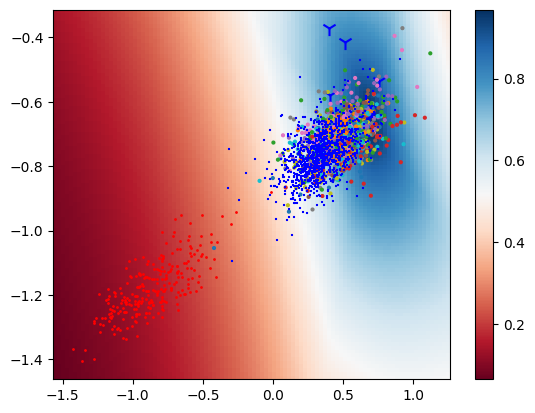

Epoch 23/50
{'G': 0.7515647930033663, 'POS': 0.7635892271995545, 'NEG': 0.17495235025565675, 'EV': 5.728006362915039e-05, 'q20': 0.6001407146453858, 'q80': 0.8762642145156861, 'auc': 0.8446332055984557}


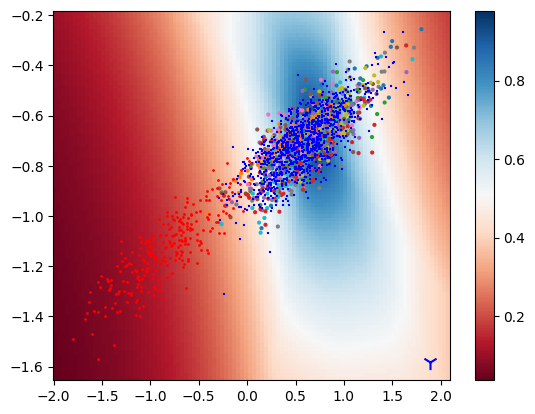

Epoch 24/50
{'G': 0.7084122082020374, 'POS': 0.7466584371759536, 'NEG': 0.210065667664117, 'EV': 0.0, 'q20': 0.572383463382721, 'q80': 0.8877627134323121, 'auc': 0.9789655096525096}


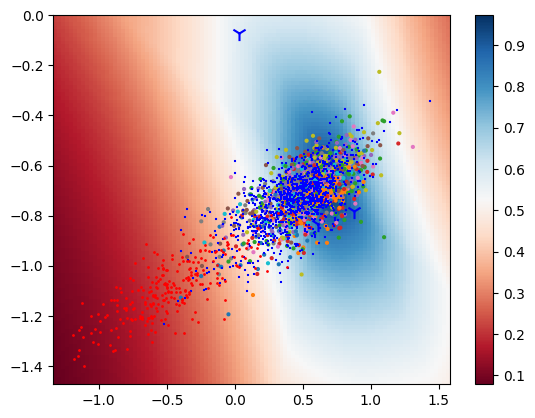

Epoch 25/50
{'G': 0.7177464379909191, 'POS': 0.7613862373727434, 'NEG': 0.19696001847215155, 'EV': 1.710653305053711e-05, 'q20': 0.5628888130187989, 'q80': 0.8866835236549377, 'auc': 0.8249287755791506}


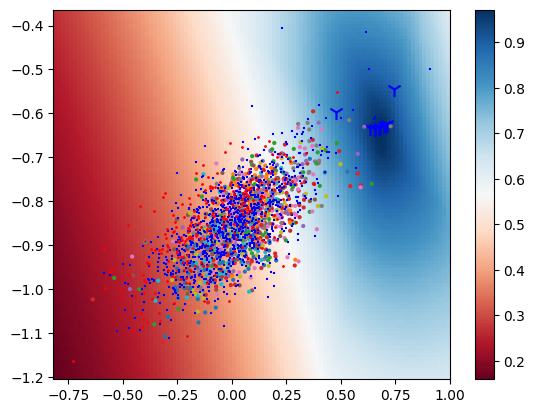

Epoch 26/50
{'G': 0.7768003841663929, 'POS': 0.7802294302493968, 'NEG': 0.1515617207089003, 'EV': 0.0, 'q20': 0.3684901833534241, 'q80': 0.5461948275566101, 'auc': 0.6862083904440155}


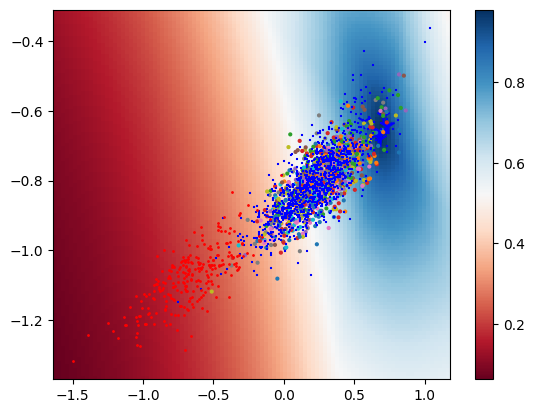

Epoch 27/50
{'G': 0.734008882274019, 'POS': 0.7584019697727041, 'NEG': 0.18726369712422503, 'EV': 0.0, 'q20': 0.4327063918113709, 'q80': 0.6660881042480469, 'auc': 0.9878606047297298}


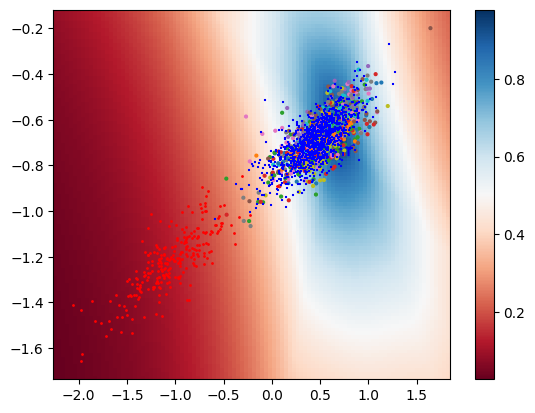

Epoch 28/50
{'G': 0.6961070289003088, 'POS': 0.7419507939447748, 'NEG': 0.21240035622043812, 'EV': 0.0, 'q20': 0.6277345418930054, 'q80': 0.901287841796875, 'auc': 0.9934214522200773}


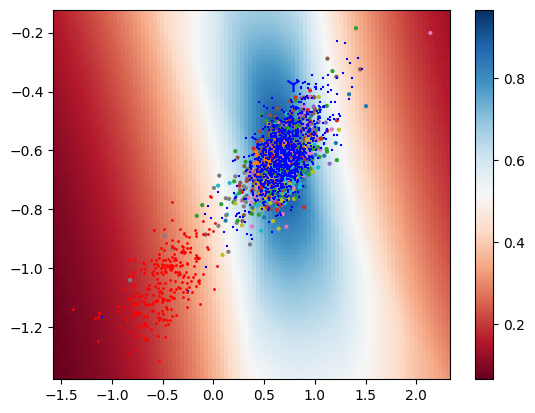

Epoch 29/50
{'G': 0.7449665453839809, 'POS': 0.7713720293755227, 'NEG': 0.1810258077021609, 'EV': 0.0, 'q20': 0.690454363822937, 'q80': 0.9158151745796204, 'auc': 0.9708196447876448}


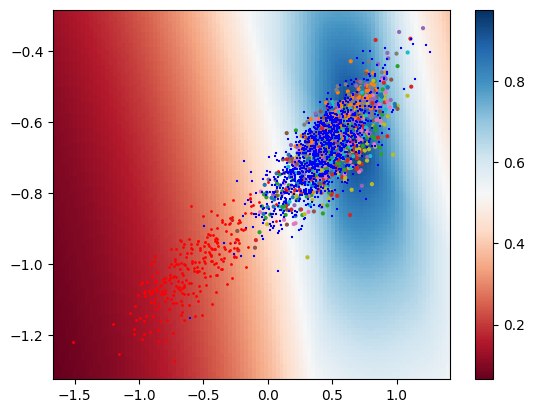

Epoch 30/50
{'G': 0.7745876033255394, 'POS': 0.764953968753206, 'NEG': 0.1637132319681188, 'EV': 0.0, 'q20': 0.6123988032341003, 'q80': 0.8938072085380554, 'auc': 0.9876036944980694}


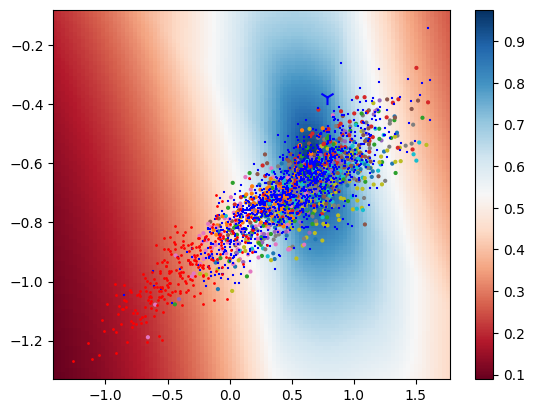

Epoch 31/50
{'G': 0.7410180815990935, 'POS': 0.7217625862106364, 'NEG': 0.18701443668217102, 'EV': 0.0, 'q20': 0.5233189463615417, 'q80': 0.8703442692756653, 'auc': 0.9207624498069498}


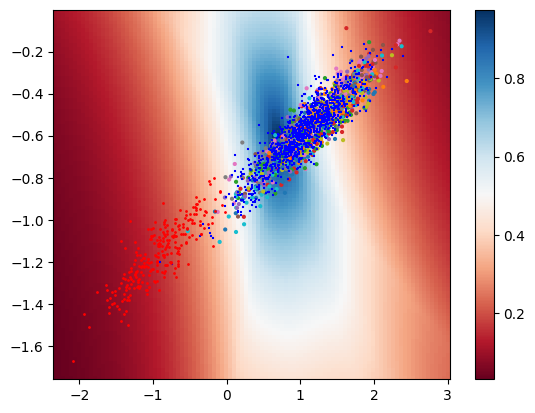

Epoch 32/50
{'G': 0.6991208827241938, 'POS': 0.7220574430328734, 'NEG': 0.21000182953603724, 'EV': 0.0, 'q20': 0.4180370569229126, 'q80': 0.8204650759696961, 'auc': 0.602731236003861}


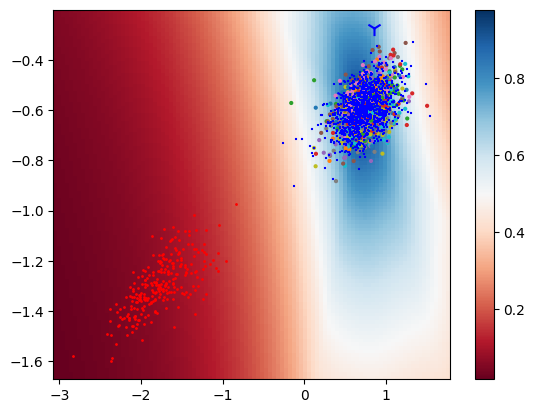

Epoch 33/50
{'G': 0.6988301334228921, 'POS': 0.7182216198520458, 'NEG': 0.21152612467871068, 'EV': 0.0, 'q20': 0.7394166469573975, 'q80': 0.9274353384971619, 'auc': 0.7641819058880308}


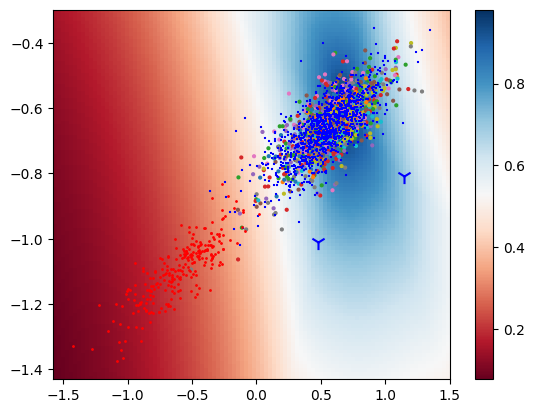

Epoch 34/50
{'G': 0.6896706479661008, 'POS': 0.7586239315093832, 'NEG': 0.21061732461477847, 'EV': 0.0, 'q20': 0.6537108898162842, 'q80': 0.9165759801864625, 'auc': 0.7863738561776061}


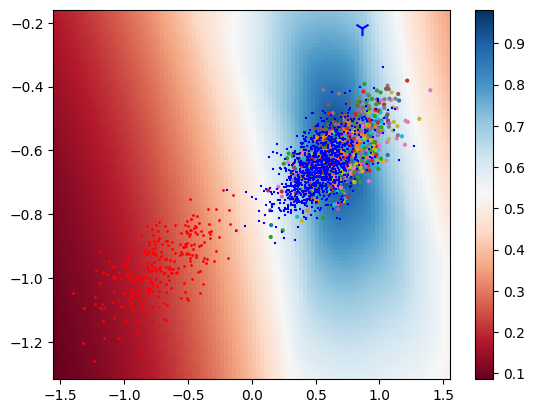

Epoch 35/50
{'G': 0.6975579535707515, 'POS': 0.7259606153089949, 'NEG': 0.2122200988629397, 'EV': 0.0, 'q20': 0.7345847129821778, 'q80': 0.9279173374176025, 'auc': 0.9620151819498068}


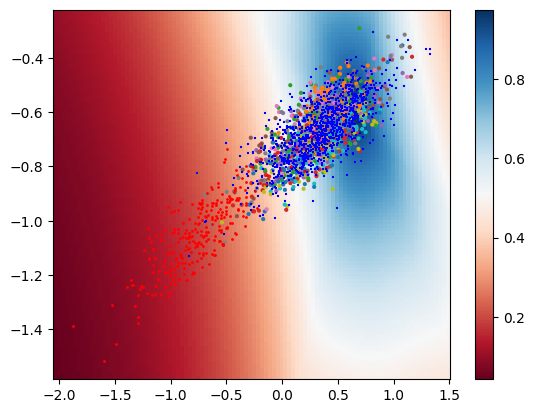

Epoch 36/50
{'G': 0.654759737024916, 'POS': 0.7350597273796162, 'NEG': 0.24606173856461303, 'EV': 0.0, 'q20': 0.4925206422805786, 'q80': 0.8438838720321655, 'auc': 0.9903953952702703}


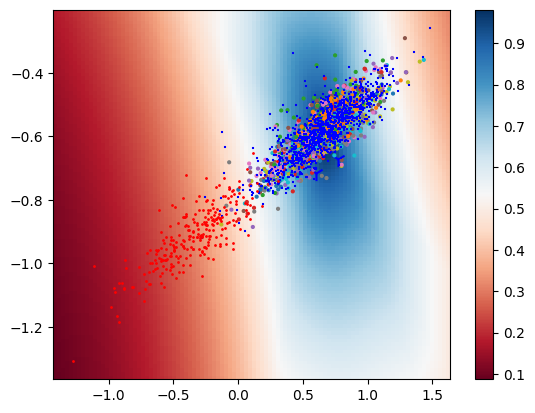

Epoch 37/50
{'G': 0.7362747920320389, 'POS': 0.7698391681021832, 'NEG': 0.1852821815521159, 'EV': 0.0, 'q20': 0.6557582736015319, 'q80': 0.9159669637680055, 'auc': 0.9997009131274132}


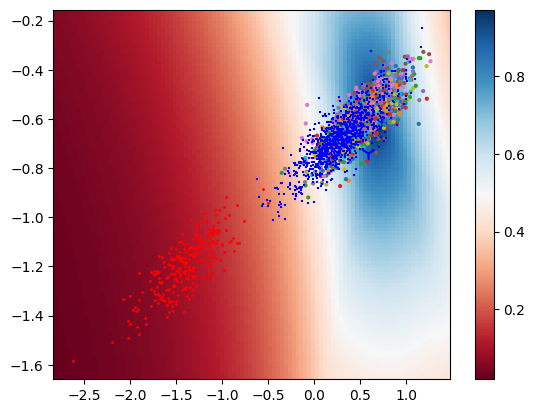

Epoch 38/50
{'G': 0.7065143014522309, 'POS': 0.7430084324897603, 'NEG': 0.2070874938463911, 'EV': 0.0, 'q20': 0.5507463216781616, 'q80': 0.8714250564575196, 'auc': 0.973620459942085}


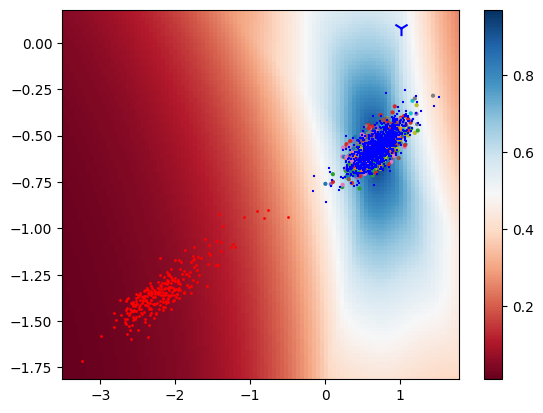

Epoch 39/50
{'G': 0.7003258632852676, 'POS': 0.7108748730826885, 'NEG': 0.21597363987660154, 'EV': 0.0, 'q20': 0.7471689701080322, 'q80': 0.9369011402130127, 'auc': 0.9076207562741311}


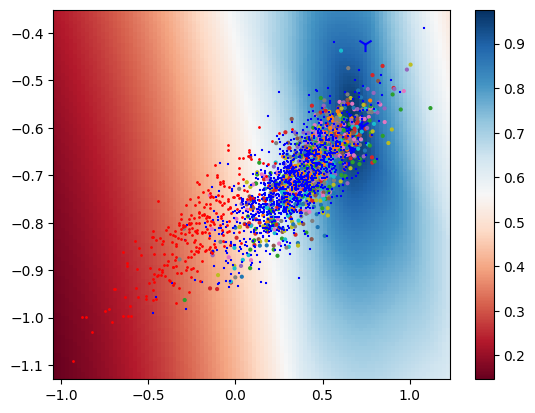

Epoch 40/50
{'G': 0.6749919564165967, 'POS': 0.7442732680351176, 'NEG': 0.23082427789873264, 'EV': 0.0, 'q20': 0.5463466167449951, 'q80': 0.8083310842514039, 'auc': 0.9843774092664092}


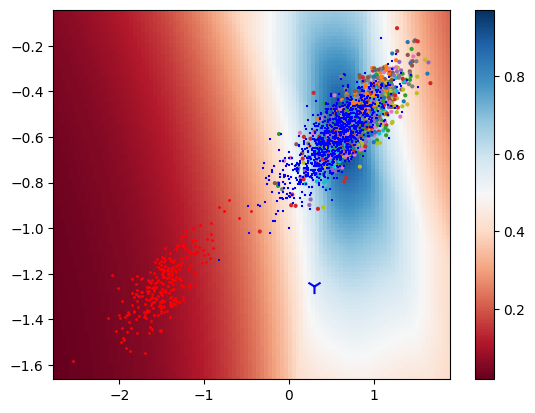

Epoch 41/50
{'G': 0.7081599943181301, 'POS': 0.7722639163757893, 'NEG': 0.20667043522079576, 'EV': 0.0, 'q20': 0.6052705526351929, 'q80': 0.8992834687232971, 'auc': 0.9783901568532818}


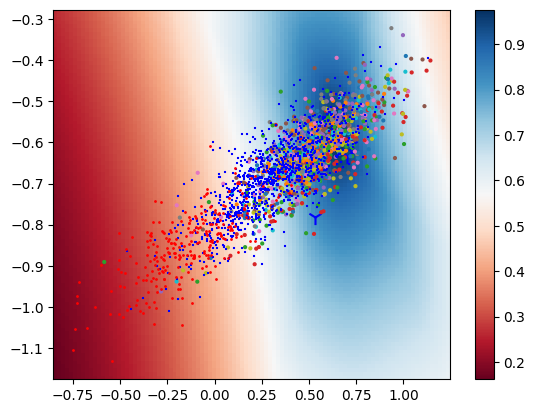

Epoch 42/50
{'G': 0.7110892261596437, 'POS': 0.7626258067628171, 'NEG': 0.2001407615364866, 'EV': 0.0, 'q20': 0.5994972944259643, 'q80': 0.8959549307823181, 'auc': 0.8268086708494209}


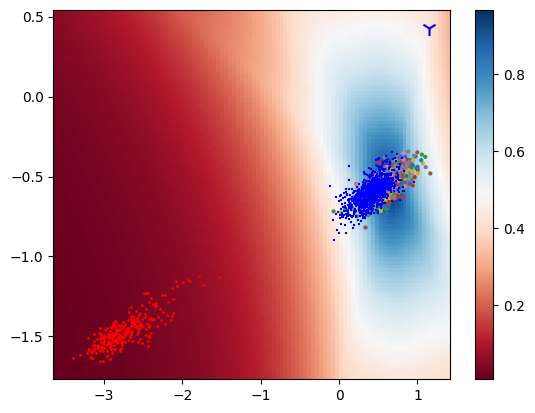

Epoch 43/50
{'G': 0.7519846331565938, 'POS': 0.7630483269691467, 'NEG': 0.17122782498320682, 'EV': 0.0, 'q20': 0.6691187858581543, 'q80': 0.9110575318336487, 'auc': 0.7952558035714286}


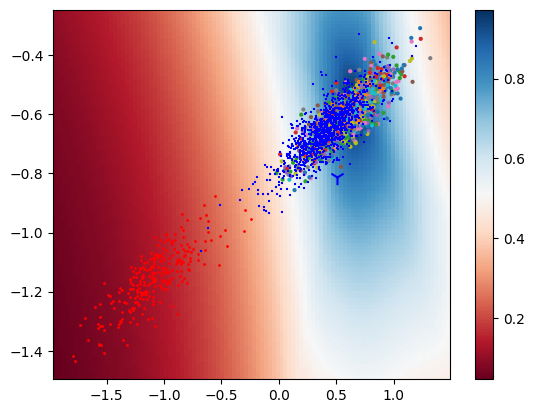

Epoch 44/50
{'G': 0.7052505521064109, 'POS': 0.7526193121646313, 'NEG': 0.19996955880617842, 'EV': 0.0, 'q20': 0.6382880210876465, 'q80': 0.9016412854194641, 'auc': 0.9917669049227799}


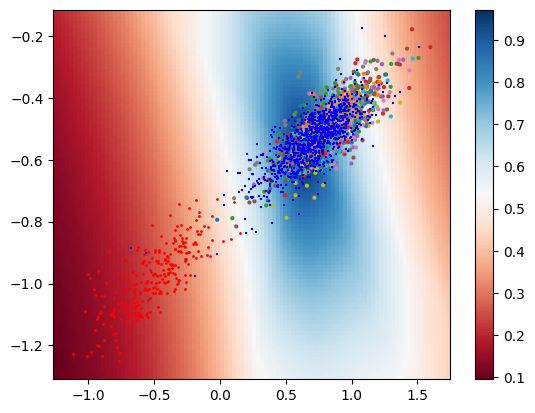

Epoch 45/50
{'G': 0.6899627135155049, 'POS': 0.7593311875424487, 'NEG': 0.21800900941833537, 'EV': 0.0, 'q20': 0.6242398023605347, 'q80': 0.9057775497436524, 'auc': 0.9188258474903475}


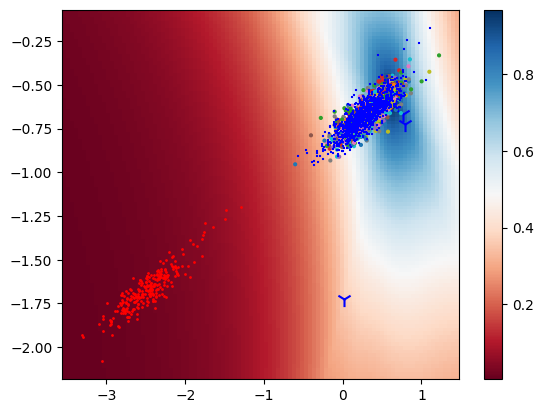

Epoch 46/50
{'G': 0.6968248505541619, 'POS': 0.7702923116531778, 'NEG': 0.21466791362680018, 'EV': 0.0, 'q20': 0.44756263494491577, 'q80': 0.7601969599723817, 'auc': 0.9993980772200772}


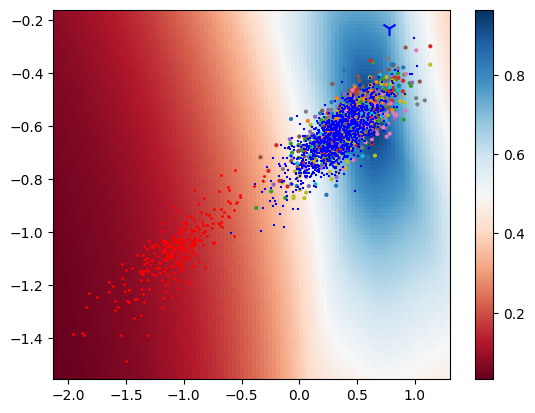

Epoch 47/50
{'G': 0.6919467058587582, 'POS': 0.7151115623560358, 'NEG': 0.21827568999947386, 'EV': 0.0, 'q20': 0.5573206663131713, 'q80': 0.8704207420349122, 'auc': 0.9984476761583011}


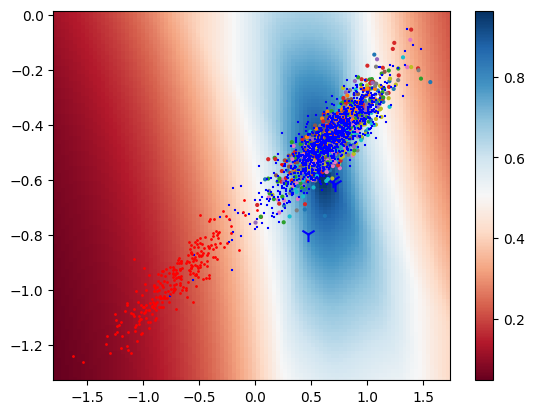

Epoch 48/50
{'G': 0.6747368635015285, 'POS': 0.7398747529121156, 'NEG': 0.23563348818966684, 'EV': 0.0, 'q20': 0.6295118689537049, 'q80': 0.89784095287323, 'auc': 0.961185473938224}


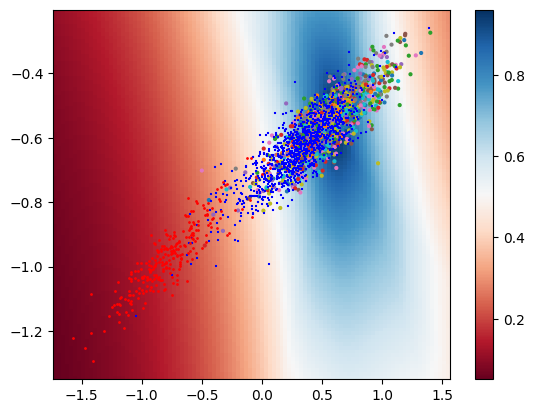

Epoch 49/50
{'G': 0.6982816313175445, 'POS': 0.7388153915709638, 'NEG': 0.2137295024112818, 'EV': 0.0, 'q20': 0.5493181824684144, 'q80': 0.8792903065681458, 'auc': 0.9983280902509652}


In [57]:
netG.train()
netD.train()

for epoch in range(niter):
    report_aver_pos = 0
    report_aver_neg = 0
    report_loss_G = 0
    report_ev = 0
    local_count = 0
    
    for i, data in enumerate(tqdm(train_loader, desc='Training', disable=True)):
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        
        netD.zero_grad()
        
        firing = netD(real_cpu)
        
        errD_real = torch.square(1 - firing).mean()
        ev_loss = keep_eigenvals_positive_loss(netD.real[0])
        if ev_loss > 0:
            errD_real.backward(retain_graph=True)
            ev_loss.backward()
        else:
            errD_real.backward()
        report_ev = np.maximum(report_ev, ev_loss.item())
        
        nfiring = netD(fake.detach())
        errD_fake = torch.square(nfiring).mean()
        ev_loss = keep_eigenvals_positive_loss(netD.real[0])
        if ev_loss > 0:
            errD_fake.backward(retain_graph=True)
            ev_loss.backward()
        else:
            errD_fake.backward()
        report_ev = np.maximum(report_ev, ev_loss.item())
        
        optimizerD.step()
        
        netD.zero_grad()
        netG.zero_grad()
        genr = netD(fake)
        errG = torch.square(1 - genr).mean() 
        errG.backward()
        optimizerG.step()
        
        local_count += 1
        report_loss_G += errG.item()
        report_aver_pos += firing.mean().item()
        report_aver_neg += nfiring.mean().item()
        
    with torch.no_grad():
        losses = {}
        
        losses['G'] = report_loss_G / local_count
        losses['POS'] = report_aver_pos / local_count
        losses['NEG'] = report_aver_neg / local_count
        losses['EV'] = report_ev
        
        writer.add_scalars('Loss', losses, epoch)
        fake = netG(fixed_noise_for_report)
        writer.add_images('Generated images', fake.detach(), epoch)
        draw_embeddings(netD, netG, epoch)    
        
        mnist_distr, auc, _ = get_test_arate_distr(netD)
        mnist_distr_q = {}
        mnist_distr_q["q20"] = np.quantile(mnist_distr, 0.2)
        mnist_distr_q["q80"] = np.quantile(mnist_distr, 0.8)
        writer.add_scalars("MNIST test  firings", mnist_distr_q, epoch)
        writer.add_scalar("AUC", auc, epoch)
        mnist_distr_q["auc"] = auc
        
        print(f"Epoch {epoch}/{niter}")
        print({**losses, **mnist_distr_q})
    

In [58]:
torch.save(netD.state_dict(), 'weights/netD.pth')
torch.save(netG.state_dict(), 'weights/netG.pth')

## Валидация

In [59]:
D = Discriminator(ndf).to(device)
G = Generator(ngf, nz).to(device)
D.load_state_dict(torch.load('weights/netD.pth'))
G.load_state_dict(torch.load('weights/netG.pth'))
#DO NOT USE EVAL

<All keys matched successfully>

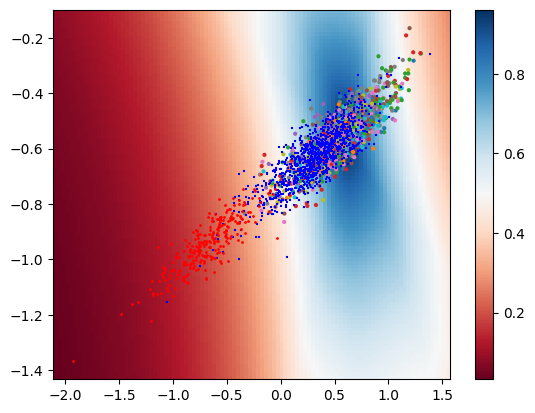

In [60]:
draw_embeddings(D, G, niter)

In [61]:
firings, auc, threshold = get_test_arate_distr(D)
print(F"Average firing {firings.mean()}")
print(F"AUC {auc} Threshold {threshold}")


Average firing 0.7066618204116821
AUC 0.9983280902509652 Threshold [1.9609361e+00 9.6093607e-01 9.1563880e-01 ... 1.8622354e-02 1.8621307e-02
 1.2375046e-03]


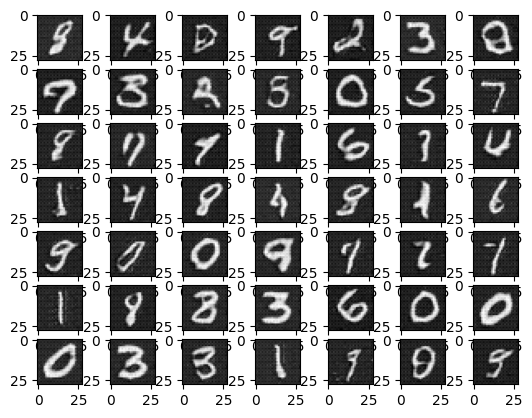

In [62]:
with torch.no_grad():
    batch_size = 49
    latent_size = 100
    
    fixed_noise = torch.randn(batch_size, latent_size, 1, 1)
    if torch.cuda.is_available():
        fixed_noise = fixed_noise.cuda()
    fake_images = G(fixed_noise)

    fake_images_np = fake_images.cpu().detach().numpy()
    fake_images_np = fake_images_np.reshape(fake_images_np.shape[0], 28, 28)
    R, C = 7, 7
    for i in range(batch_size):
        plt.subplot(R, C, i + 1)
        plt.imshow(fake_images_np[i], cmap='gray')
    plt.show()

In [63]:
def get_arate(inp):
    return D(inp)

inp = torch.rand((2,1,28,28))
get_arate(inp.to(device))

tensor([0.0013, 0.0003], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [64]:
centroids_r = D.real[0].get_centroids().detach().cpu().numpy()
centroids_r

array([[ 0.6094872 , -0.5207645 ],
       [ 0.6418886 , -0.546058  ],
       [ 0.5649577 , -0.5414301 ],
       [ 0.6324    , -0.5221134 ],
       [ 0.63379663, -0.5160011 ],
       [ 0.55036575, -0.5686441 ],
       [ 0.568969  , -0.53297424],
       [ 0.5595864 , -0.621454  ],
       [ 0.6687151 , -0.55829126],
       [ 0.5373521 , -0.5425261 ]], dtype=float32)

Encoding:   0%|          | 0/40 [00:00<?, ?it/s]

Encoding:   0%|          | 0/405 [00:00<?, ?it/s]

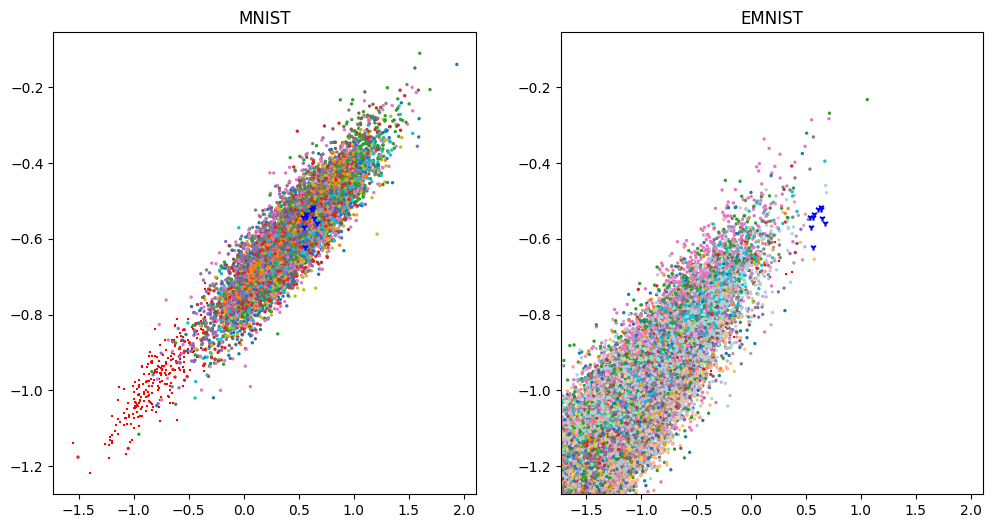

In [65]:
embedings_fake = []

with torch.no_grad():
    batch_size = 256
    latent_size = 100
    
    fixed_noise = torch.randn(batch_size, latent_size, 1, 1)
    if torch.cuda.is_available():
        fixed_noise = fixed_noise.cuda()
    fake_images = G(fixed_noise)
    embeding = D.main(fake_images)
    embedings_fake.append(embeding.cpu().numpy())

embedings_fake = np.concatenate(embedings_fake, axis=0)    

embedings = []
labels_expected = []
with torch.no_grad():
    for data, target in tqdm(test_loader, desc='Encoding'):
        data = data.view((-1,1,28,28)).to(device)
        embeding = D.main(data)
        embedings.append(embeding.cpu().numpy())
        labels_expected.append(np.argmax(target.squeeze(1).cpu().numpy(), axis=1))
embedings = np.concatenate(embedings, axis=0)
labels_expected = np.concatenate(labels_expected, axis=0)

emnist_embedings = []
emnist_labels_expected = []
with torch.no_grad():
    for data, target in tqdm(emnist_loader, desc='Encoding'):
        data = data.view((-1,1,28,28)).to(device)
        embeding = D.main(data)
        emnist_embedings.append(embeding.cpu().numpy())
        emnist_labels_expected.append(target.cpu().numpy())
emnist_embedings = np.concatenate(emnist_embedings, axis=0)
emnist_labels_expected = np.concatenate(emnist_labels_expected, axis=0)
plt.figure(figsize=(12, 6))

R, C = 1, 2

plt.subplot(R, C, 1)
plt.title("MNIST")
plt.scatter(embedings_fake[:, 0], embedings_fake[:, 1], c='red', marker='+', s=4)
plt.scatter(embedings[:, 0],      embedings[:,  1], c=labels_expected, cmap='tab10', s=2)
plt.scatter(centroids_r[:, 0],    centroids_r[:,1], marker='1', c='blue', s= 20)
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
plt.subplot(R, C, 2)
plt.title("EMNIST")
plt.scatter(embedings_fake[:, 0], embedings_fake[:, 1], c='red', marker='+', s=4)
plt.scatter(emnist_embedings[:, 0], emnist_embedings[:, 1], c=emnist_labels_expected, cmap='tab20', s=2)
plt.scatter(centroids_r[:, 0], centroids_r[:, 1], marker='1', c='blue', s= 20)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.show()

MNIST HIST:   0%|          | 0/40 [00:00<?, ?it/s]

EMNIST HIST:   0%|          | 0/405 [00:00<?, ?it/s]

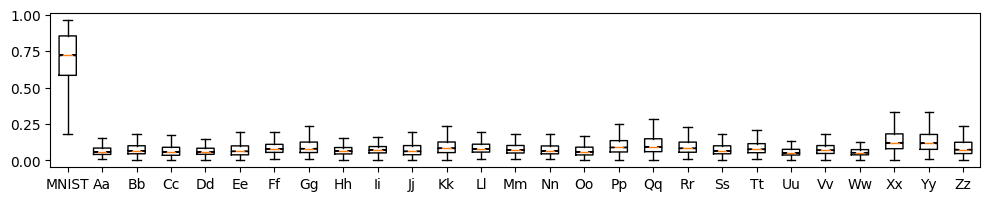

In [66]:
firing_levels = []
with torch.no_grad():
    for data, target in tqdm(test_loader, desc='MNIST HIST'):
        data = data.view((-1,1,28,28)).to(device)
        rates = get_arate(data)
        firing_levels.append(rates.cpu().numpy())
        
firing_levels = np.concatenate(firing_levels, axis=0)

firings_emnist = {}
for m in emnist_mapping:
    firings_emnist[emnist_mapping[m]] = []

with torch.no_grad():
    for data, labels in tqdm(emnist_loader, desc='EMNIST HIST'):
        data = data.view((-1, 1, 28, 28)).to(device) 
        arate = get_arate(data)
        for label, flabel in zip(labels, arate.cpu().numpy()):
            firings_emnist[emnist_mapping[label.item()]].append(flabel)

firings_mnist = {}
firings_mnist['MNIST'] = firing_levels
firings = {**firings_mnist, **firings_emnist} 
labels, data = firings.keys(), firings.values()

fig = plt.figure(figsize =(12, 2))
plt.boxplot(data, notch=True, showfliers=False)
plt.xticks(range(1, len(labels) + 1), labels)
plt.show()

writer.add_figure('Anomaly Detection', fig)

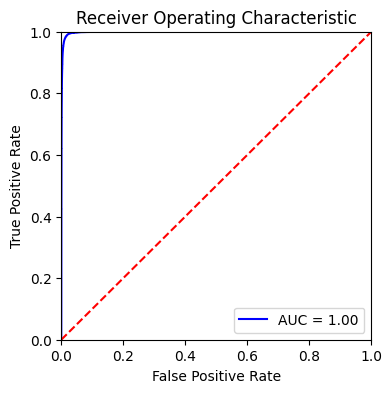

In [67]:
lab_true = []
lab_pred = []
for k,v in firings_mnist.items():
    for p in v:
        lab_true.append(1)
        lab_pred.append(p)
for k,v in firings_emnist.items():
    for p in v:
        lab_true.append(0)
        lab_pred.append(p)

fpr, tpr, threshold = metrics.roc_curve(lab_true, lab_pred)
roc_auc = metrics.auc(fpr, tpr)

fig = plt.figure(figsize =(4, 4))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
writer.add_figure('ROC', fig)

EMNIST VIS:   0%|          | 0/405 [00:00<?, ?it/s]

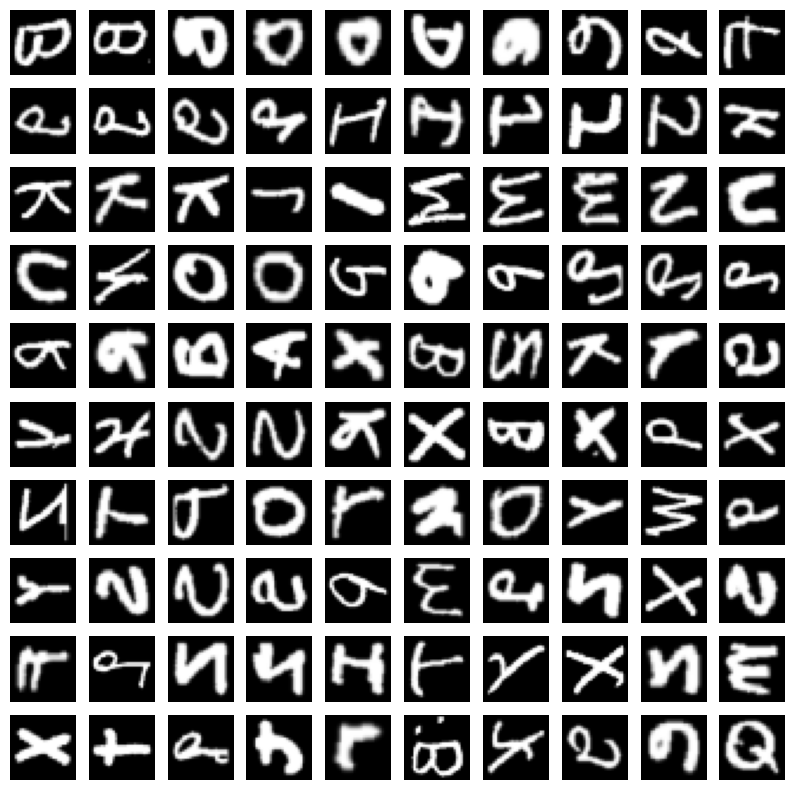

In [68]:
threshold = 0.3
n = 0
fig, ax = plt.subplots(10, 10, figsize=(10, 10))
with torch.no_grad():
    for data, labels in tqdm(emnist_loader, desc='EMNIST VIS'):
        data = data.view((-1, 1, 28, 28)).to(device) 
        arate = get_arate(data)
        winner = arate.max(-1)
        if(winner.values > threshold):
            img = data[winner.indices]
            ax[int(n / 10), int(n % 10)].imshow(img.view(28, 28).cpu().detach().numpy(), cmap='gray')
            ax[int(n / 10), int(n % 10)].axis('off')
            n = n + 1
                
            if n == 100:
                break